In [2]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [3]:
#### Preprocecing ###

In [4]:
jh_dir = "../../COVID-19"

In [5]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [6]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [8]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [9]:
### Data Preparation ###

In [10]:
country = 'Japan'
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-04-29')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [11]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [12]:
### Model ###

In [90]:
sm_seird = pystan.StanModel(file="SEIRD.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ab65fa2ef5f7011270d2ce1b7ddef7ce NOW.


In [91]:
# Train the model and generate samples
init = {'c':0.2}
inits = [init, init, init, init]
iteration=2000
T=C0.shape[0];
data = {'T': T, 'T0': 0, 'P': P, 'C0': C0[:T], 'R0': R0[:T], 'D0':D0[:T]}
fit_seird = sm_seird.sampling(data=data, iter=iteration, init=inits)
fit_seird


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_ab65fa2ef5f7011270d2ce1b7ddef7ce.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   4.42    0.13   2.97   1.13    2.5   3.66   5.47  12.25    559    1.0
init_e     1.34    0.03   1.43   0.05   0.45   0.94   1.71   5.08   2948    1.0
b_beta     0.02  1.1e-3   0.01 6.4e-3   0.01   0.02   0.03   0.04     87   1.04
b[1]       0.36  7.7e-3   0.15   0.15   0.25   0.33   0.42   0.72    372   1.01
b[2]       0.35  7.8e-3   0.14   0.16   0.26   0.33   0.42   0.72    344   1.01
b[3]       0.35  7.6e-3   0.14   0.16   0.26   0.33   0.41   0.71    344   1.01
b[4]       0.35  7.3e-3   0.13   0.16   0.25   0.32   0.41   0.68    338   1.01
b[5]       0.34  6.8e-3   0.13   0.16   0.25   0.32    0.4   0.66    355   1.01
b[6]       0.33  6.5e-3   0.12   0.16   0.25   0.31

In [ ]:
# Convergence

In [92]:
data = az.from_pystan(fit_seird, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9d3556950>,
      dtype=object)

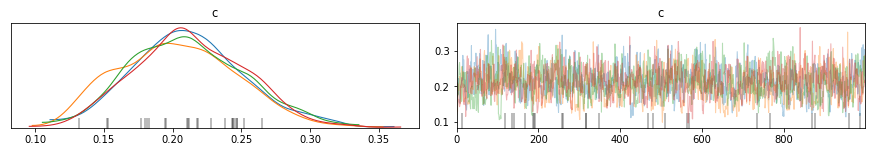

In [93]:
az.plot_trace(data, var_names=['c'])

In [17]:
# Save models

In [66]:
import pickle
with open("sm_seird_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_seird, 'fit' : fit_seird}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
### Load modesl

In [67]:
with open("sm_seird_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_seird = data_dict['model']
fit_seird = data_dict['fit']
# fit = data_list[1]

In [24]:
### model selection

In [68]:
data = az.from_pystan(fit_seird, log_likelihood='log_lik')

In [94]:
loo = az.loo(data, pointwise=True)
loo

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 98 log-likelihood matrix

       Estimate       SE
IC_loo   740.17    32.10
p_loo     92.37        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        9    9.2%
 (0.5, 0.7]   (ok)         14   14.3%
   (0.7, 1]   (bad)        59   60.2%
   (1, Inf)   (very bad)   16   16.3%

In [34]:
### Visualization ###

In [95]:
upto = epoch+pd.Timedelta(days=C0.shape[0]-2)
index= pd.date_range(start=epoch, end=upto)

In [96]:
    init_inf = pd.DataFrame(data.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
    b = pd.DataFrame(data.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
    q = pd.DataFrame(data.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
    NI = pd.DataFrame(data.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
    a = pd.DataFrame(data.posterior['a'].stack(sample=('chain', 'draw')).values)
    d = pd.DataFrame(data.posterior['d'].stack(sample=('chain', 'draw')).values)
    C = NI.cumsum().shift(periods=1).fillna(0)
    C = pd.DataFrame(np.array([C.iloc[i].values + init_inf[0].values for i in range(C.shape[0])]), index=index)
    NI0S = q*NI
    C0S = NI0S.cumsum().shift(periods=1)
    C0S = pd.DataFrame(np.array([C0S.iloc[i].values + C0[0] for i in range(C.shape[0])]), index=index)

In [97]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-26')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


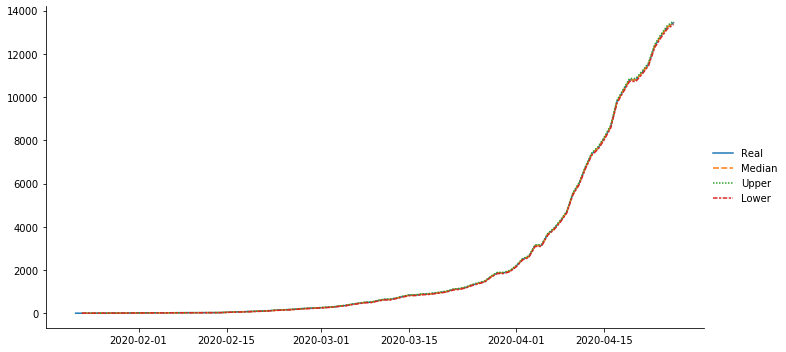

In [98]:
draw(C0S, real=confirmed[country])

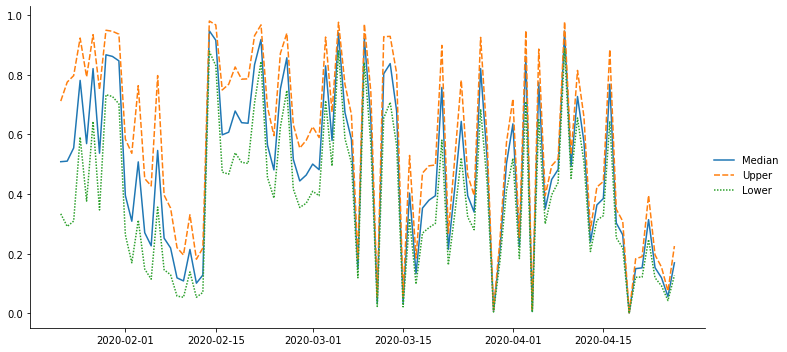

In [99]:
draw(q)

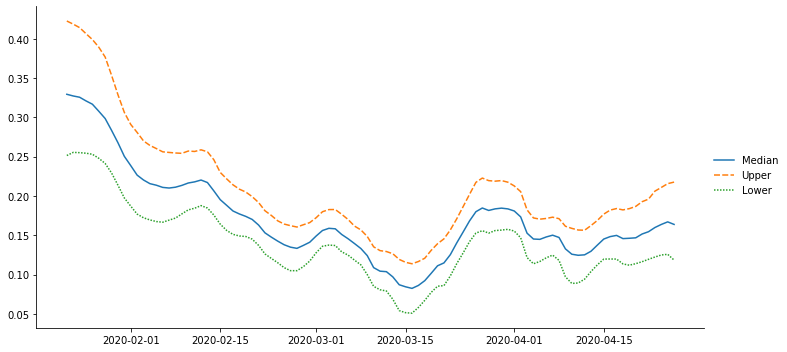

In [100]:
draw(b)

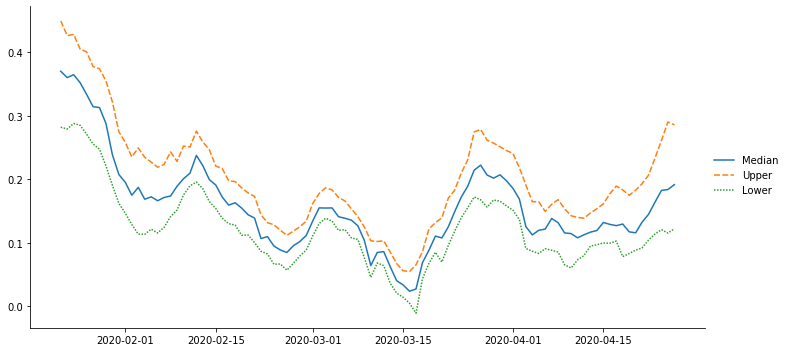

In [101]:
r = pd.DataFrame(data.posterior['r'].stack(sample=('chain', 'draw')).values)
d = pd.DataFrame(data.posterior['d'].stack(sample=('chain', 'draw')).values)
beta = pd.DataFrame(np.array([b[i].values - r.iloc[i].values for i in range(len(b))]).T, index=b.index)
draw(beta)

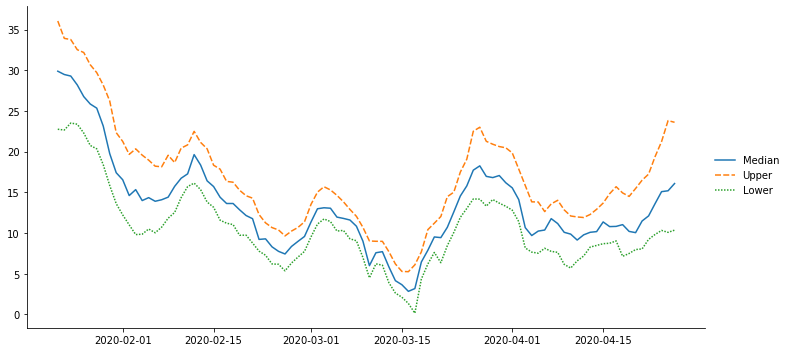

In [102]:
R0 = pd.DataFrame(np.array([b[i].values / r.iloc[i].values for i in range(len(b))]).T, index=b.index)
draw(R0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9d71d95d0>],
      dtype=object)

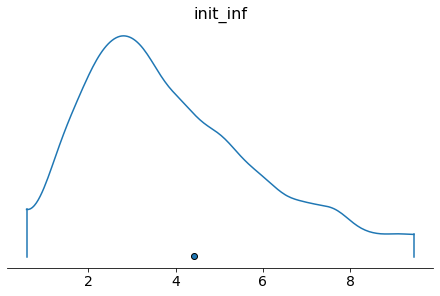

In [103]:
az.plot_density(data, var_names=['init_inf'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9e4730d90>],
      dtype=object)

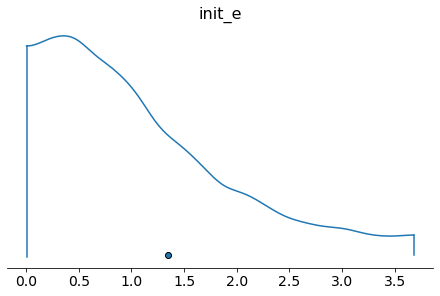

In [104]:
az.plot_density(data, var_names=['init_e'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9d7294890>],
      dtype=object)

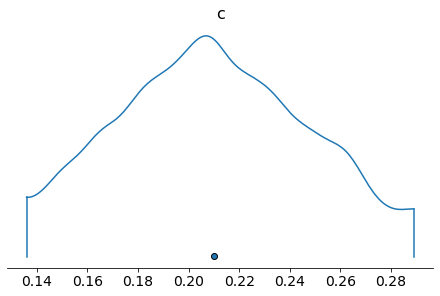

In [105]:
az.plot_density(data, var_names=['c'])